In [1]:
from src.functions import *

import numpy as np
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply, expm
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from scipy.optimize import brent, minimize_scalar, minimize
import joblib

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator, Statevector, Pauli
from qiskit_aer import AerSimulator

In [2]:
# Global setting
with open('./setting.json', 'r') as f:
    setting = json.load(f)
    _gamma = setting["gamma"]
    _T = setting["T"]
    _t = setting["t"]
    _num_random_models = setting["num_random_models"]

# Load the JSON file
with open('./instances.json', 'r') as f:
    instances = json.load(f)

In [3]:
def prepare_initial_state(index, N):
    qreg = QuantumRegister(N)
    init_circ = QuantumCircuit(qreg)
    for qubit in range(N):
        if (index >> qubit) & 1:
            init_circ.x(qreg[qubit])
    return init_circ

def create_QAOA_Hamiltonian(m):
    N = m.n
    J = m.J_rescaled
    h = m.h_rescaled

    H1_z_strings = []
    H1_z_coeff = []
    H1_x_strings = []
    H1_x_coeff = []

    for i in range(N):
        H1_z_strings.append((i*"I" + "Z" + (N - 1 - i)*"I"))
        H1_z_coeff.append(h[i])
        H1_x_strings.append((i*"I" + "X" + (N - 1 - i)*"I"))
        H1_x_coeff.append(1)

    H2_strings = []
    H2_coeffs = []
    for i in range(N):
        for j in range(i + 1, N):
            op_string = i*"I" + "Z" + (j - i - 1)*"I" + "Z" + (N - 1 - j)*"I"
            coeff = J[i][j]
            H2_strings.append(op_string)
            H2_coeffs.append(coeff)

    H1_z_ops = SparsePauliOp(data=H1_z_strings, coeffs=H1_z_coeff)
    H1_x_ops = SparsePauliOp(data=H1_x_strings, coeffs=H1_x_coeff)
    H2_ops = SparsePauliOp(data=H2_strings, coeffs=H2_coeffs)

    Hz_ops = H1_z_ops + H2_ops
    Hx_ops = H1_x_ops

    return Hz_ops, Hx_ops

In [4]:
def QAOA_circuit(m, theta, layer_count=50, init_circ=None):
    N = m.n
    qreg = QuantumRegister(N)
    qaoa_circ = QuantumCircuit(qreg)
    H_prob, H_mix = create_QAOA_Hamiltonian(m)

    if init_circ is not None:
        qaoa_circ.append(init_circ, qreg)

    for layer in range(layer_count):

        mixer_op = PauliEvolutionGate(H_mix, time=theta)
        qaoa_circ.append(mixer_op, range(N))

        evolution_op = PauliEvolutionGate(H_prob, time=theta)
        qaoa_circ.append(evolution_op, range(N))
    
    for layer in range(layer_count):
        
        evolution_op = PauliEvolutionGate(H_prob, time=theta)
        qaoa_circ.append(evolution_op, range(N))

        mixer_op = PauliEvolutionGate(H_mix, time=theta)
        qaoa_circ.append(mixer_op, range(N))

    return qaoa_circ

def get_proposal_QAOA(m, theta):
    circuit = QAOA_circuit(m, theta)
    C = Operator(circuit).data
    Q_hat = np.abs(C)**2
    return Q_hat

def cost_function(m, theta, T=1):
    proposal_QAOA = get_proposal_QAOA(m, theta)
    P_QAOA = get_transition_matrix(m, _T, proposal_QAOA)
    delta_simulation = get_delta(P_QAOA)

    return delta_simulation

In [5]:
def QAOA_circuit_v2(m, theta, init_circ=None):
    N = m.n
    qreg = QuantumRegister(N)
    qaoa_circ = QuantumCircuit(qreg)
    layer_count = 50
    H_prob, H_mix = create_QAOA_Hamiltonian(m)

    if init_circ is not None:
        qaoa_circ.append(init_circ, qreg)

    for layer in range(layer_count):

        mixer_op = PauliEvolutionGate(H_mix, time=theta)
        qaoa_circ.append(mixer_op, range(N))

        evolution_op = PauliEvolutionGate(H_prob, time=theta)
        qaoa_circ.append(evolution_op, range(N))
    
    for layer in range(layer_count):
        
        evolution_op = PauliEvolutionGate(H_prob, time=theta)
        qaoa_circ.append(evolution_op, range(N))

        mixer_op = PauliEvolutionGate(H_mix, time=theta)
        qaoa_circ.append(mixer_op, range(N))

    return qaoa_circ

def boltzmann_distribution(m, x, T):
    E_x = m.E[x]
    Z = np.sum(np.exp(-m.E / T))
    mu_x = np.exp(-E_x / T) / Z
    return mu_x

def cost_function_v2(m, theta, T=1):
    N = m.n
    total_acceptance = 0
    
    circuit = QAOA_circuit_v2(m, theta)
    C = Operator(circuit).data
    Q_hat = np.abs(C)**2

    E_rowstack = np.tile(m.E, (2**N, 1))
    E_diff = E_rowstack.T - E_rowstack
    uphill_moves = (E_diff >= 0)

    if T > 0:
        pi_ratio = np.exp(-E_diff/T, where=uphill_moves, out=np.ones_like(E_diff))
    if T == 0:
        pi_ratio = np.where(uphill_moves, 0., 1.)
    A = pi_ratio

    for x in range(2**N):
        for y in range(2**N):
            total_acceptance += boltzmann_distribution(m, x, T) * Q_hat[y, x] * A[y, x]

    return total_acceptance

def get_proposal_QAOA_v2(m, theta):
    circuit = QAOA_circuit_v2(m, theta)
    C = Operator(circuit).data
    Q_hat = np.abs(C)**2
    return Q_hat


In [6]:
delta_random_avgs = []
delta_random_stds = []
delta_local_avgs = []
delta_local_stds = []
delta_quantum_avgs = []
delta_quantum_stds = []
delta_QAOA_avgs = []
delta_QAOA_stds = []
delta_QAOA_v2_avgs = []
delta_QAOA_v2_stds = []

In [7]:
for N in tqdm(range(3, 10)):
    def f(instance):
        m = IsingModel.from_coefficients(N, instance)

        def objective(theta):
                return -cost_function(m, theta)  # Negative because we maximize

        result = minimize_scalar(objective, bounds=(0, 0.3), method='bounded')

        optimized_theta = result.x
        delta = -result.fun
        
        proposal_mat_random = get_proposal_mat_random(m)
        P_random = get_transition_matrix(m, _T, proposal_mat_random)
        delta_random = get_delta(P_random)

        proposal_mat_local = get_proposal_mat_local(m)
        P_local = get_transition_matrix(m, _T, proposal_mat_local)
        delta_local = get_delta(P_local)

        proposal_mat_quantum = get_proposal_mat_quantum(m, gamma=_gamma, t=_t)
        P_quantum = get_transition_matrix(m, _T, proposal_mat_quantum)
        delta_quantum = get_delta(P_quantum)

        proposal_QAOA = get_proposal_QAOA(m, optimized_theta)
        P_QAOA = get_transition_matrix(m, _T, proposal_QAOA)
        delta_QAOA = get_delta(P_QAOA)

        return delta_random, delta_local, delta_quantum, delta_QAOA

    def f2(instance):
        m = IsingModel.from_coefficients(N, instance)

        def objective(theta):
            return cost_function_v2(m, theta)

        result = minimize_scalar(objective, bounds=(0, 0.3), method='bounded')

        optimal_theta = result.x
        optimal_AR = result.fun

        proposal_QAOA = get_proposal_QAOA_v2(m, optimal_theta)
        P_QAOA = get_transition_matrix(m, _T, proposal_QAOA)
        delta_QAOA_2 = get_delta(P_QAOA)

        return delta_QAOA_2


    sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f)(instance) for instance in instances[f'{N}']))
    sweep_data = sweep_data.swapaxes(0,1)
    delta_random = sweep_data[0]
    delta_local = sweep_data[1]
    delta_quantum = sweep_data[2]
    delta_QAOA = sweep_data[3]

    sweep_data_2 = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f2)(instance) for instance in instances[f'{N}']))
    delta_QAOA_v2 = sweep_data_2

    delta_random_avgs.append(np.mean(delta_random, axis=0))
    delta_random_stds.append(np.std(delta_random, axis=0))

    delta_local_avgs.append(np.mean(delta_local, axis=0))
    delta_local_stds.append(np.std(delta_local, axis=0))

    delta_quantum_avgs.append(np.mean(delta_quantum, axis=0))
    delta_quantum_stds.append(np.std(delta_quantum, axis=0))

    delta_QAOA_avgs.append(np.mean(delta_QAOA, axis=0))
    delta_QAOA_stds.append(np.std(delta_QAOA, axis=0))

    delta_QAOA_v2_avgs.append(np.mean(delta_QAOA_v2, axis=0))
    delta_QAOA_v2_stds.append(np.std(delta_QAOA_v2, axis=0))

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:26<02:38, 26.36s/it]

 29%|██▊       | 2/7 [00:54<02:16, 27.28s/it]

 43%|████▎     | 3/7 [01:29<02:04, 31.03s/it]

 57%|█████▋    | 4/7 [02:20<01:56, 38.97s/it]

 71%|███████▏  | 5/7 [04:00<02:01, 60.73s/it]

 86%|████████▌ | 6/7 [09:03<02:23, 143.07s/it]

100%|██████████| 7/7 [36:39<00:00, 637.75s/it]

100%|██████████| 7/7 [36:39<00:00, 314.19s/it]

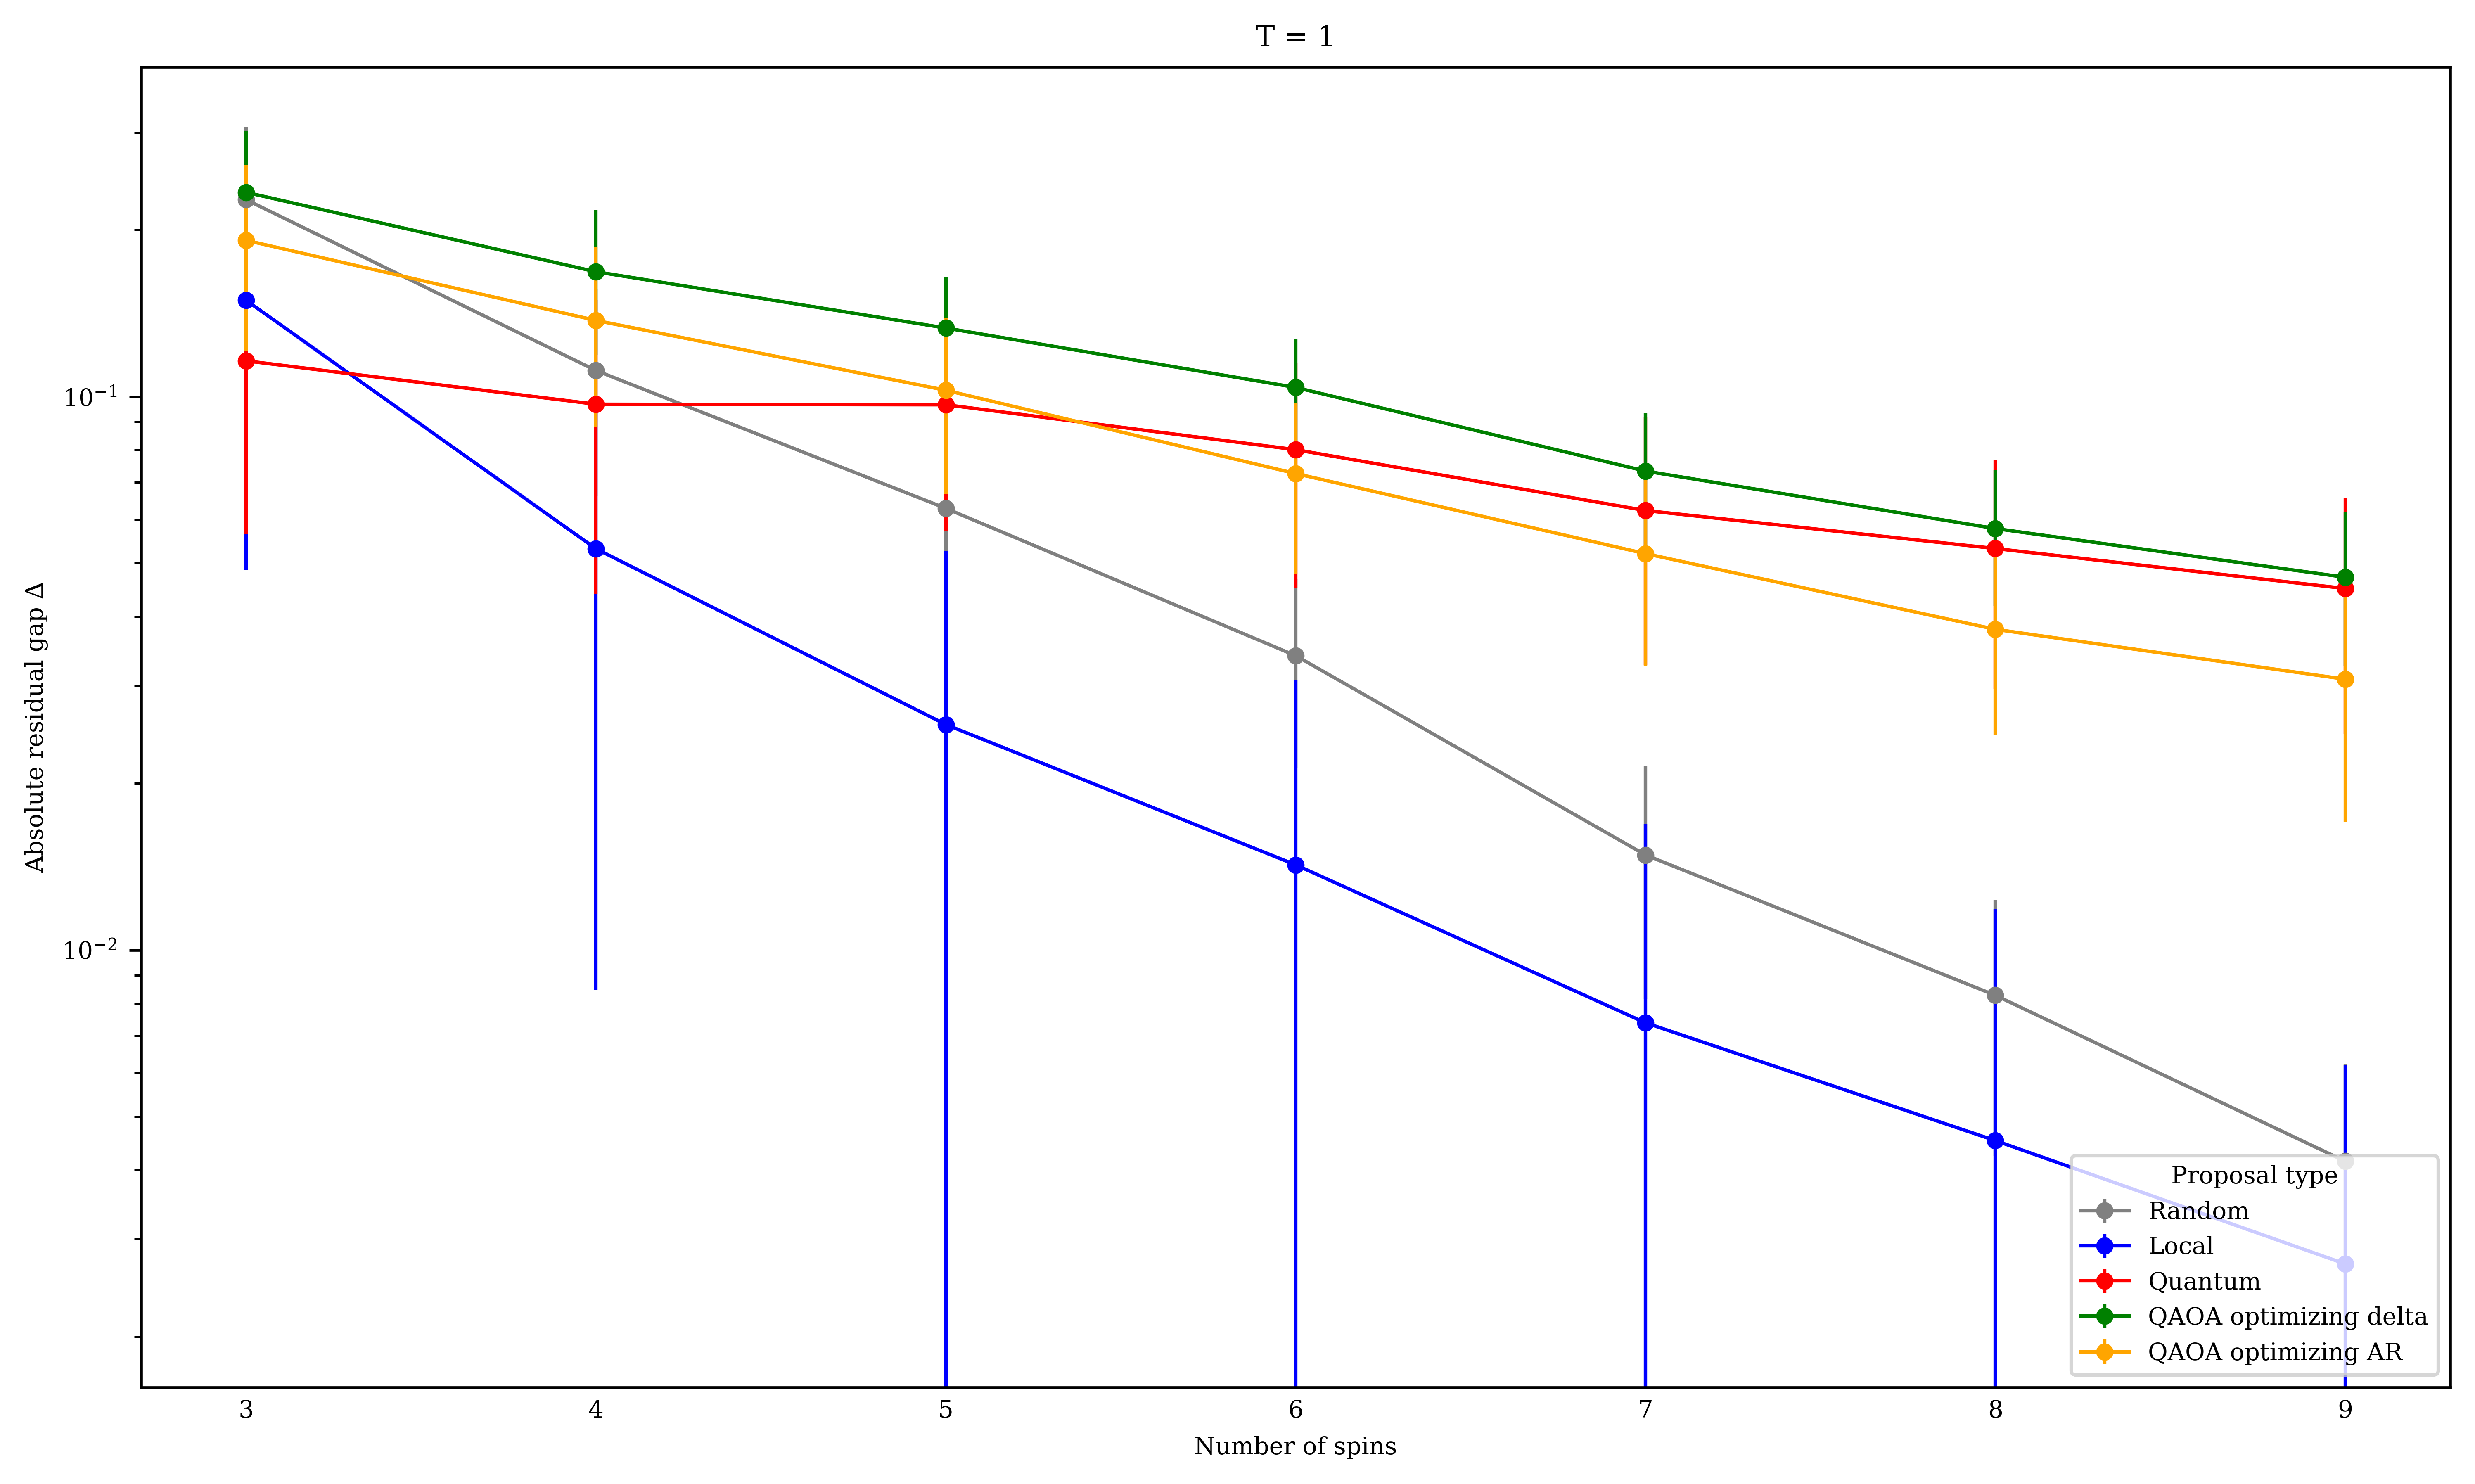

In [8]:
x = np.arange(3, 10)

plt.figure(figsize=(10, 6))

plt.errorbar(x, delta_random_avgs, yerr=delta_random_stds, fmt='o-', label='Random', color='grey')
plt.errorbar(x, delta_local_avgs, yerr=delta_local_stds, fmt='o-', label='Local', color='blue')
plt.errorbar(x, delta_quantum_avgs, yerr=delta_quantum_stds, fmt='o-', label='Quantum', color='red')
plt.errorbar(x, delta_QAOA_avgs, yerr=delta_QAOA_stds, fmt='o-', label='QAOA optimizing delta', color='green')
plt.errorbar(x, delta_QAOA_v2_avgs, yerr=delta_QAOA_v2_stds, fmt='o-', label='QAOA optimizing AR', color='orange')

plt.yscale('log')

plt.xlabel('Number of spins')
plt.ylabel('Absolute residual gap Δ')
plt.legend(loc='lower right', title='Proposal type')
plt.title('T = 1')

plt.tight_layout()
plt.show()

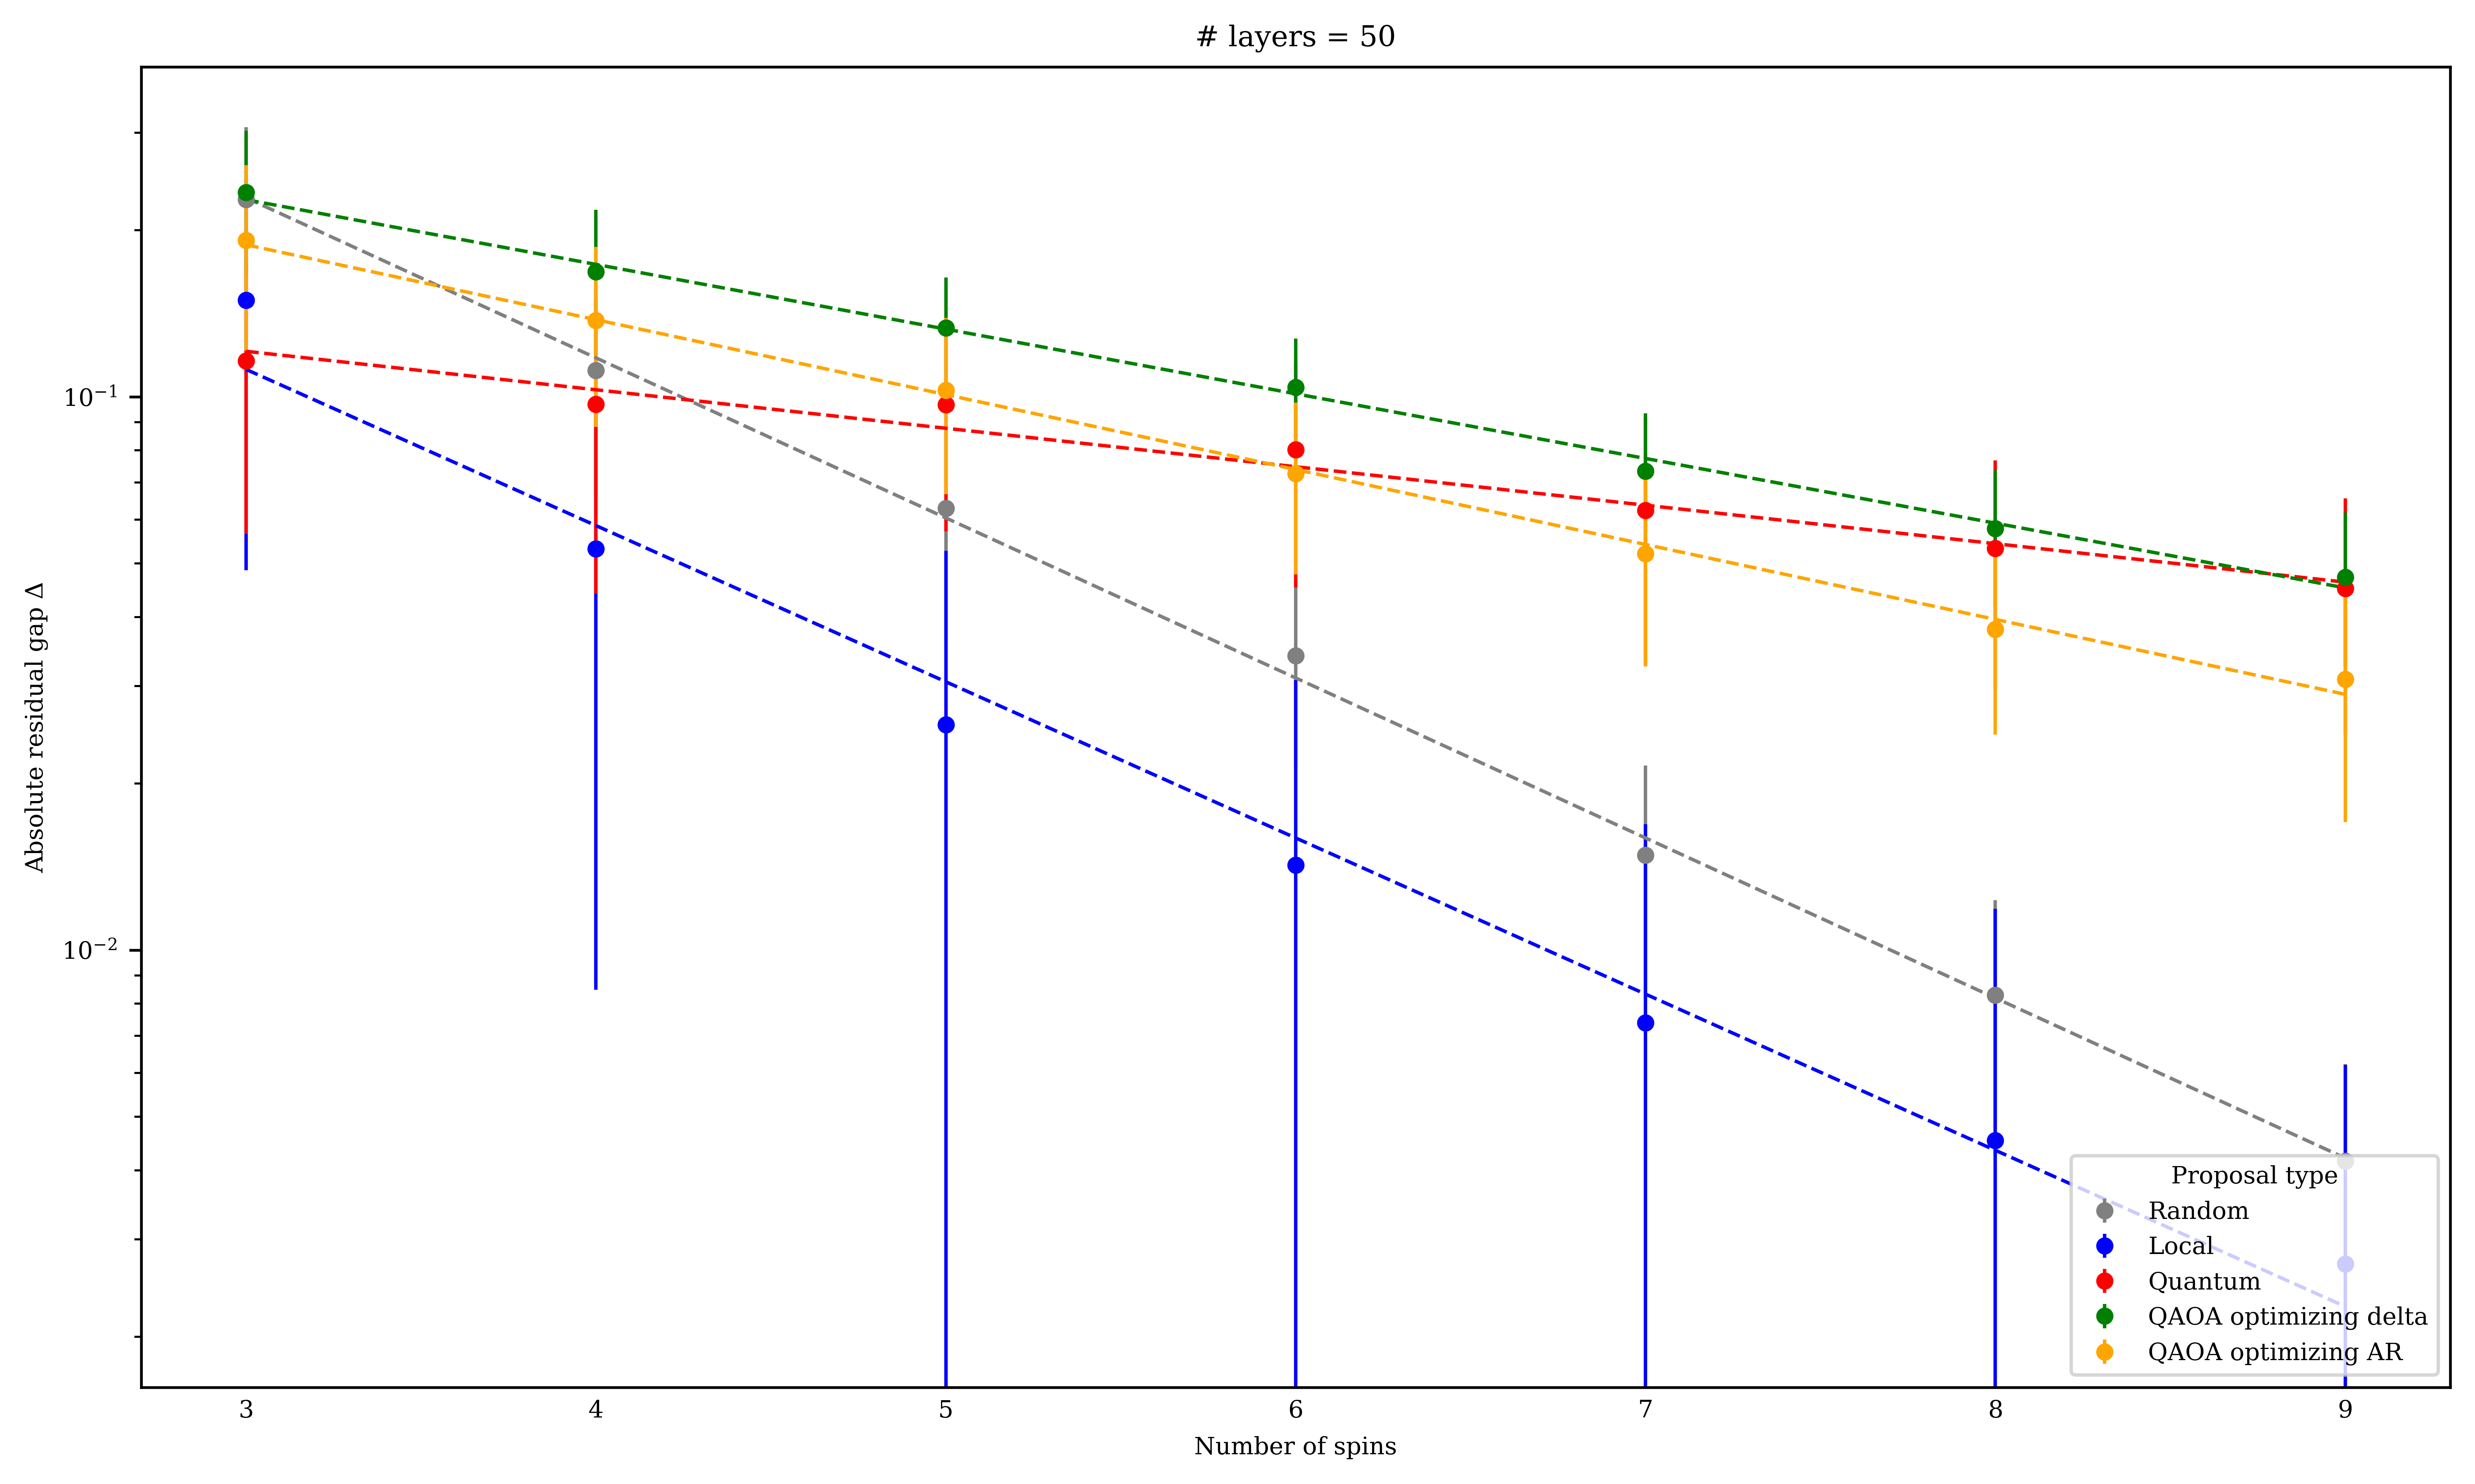

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = np.arange(3, 10)

plt.figure(figsize=(10, 6))

plt.errorbar(x, delta_random_avgs, yerr=delta_random_stds, fmt='o', label='Random', color='grey')
plt.errorbar(x, delta_local_avgs, yerr=delta_local_stds, fmt='o', label='Local', color='blue')
plt.errorbar(x, delta_quantum_avgs, yerr=delta_quantum_stds, fmt='o', label='Quantum', color='red')
plt.errorbar(x, delta_QAOA_avgs, yerr=delta_QAOA_stds, fmt='o', label='QAOA optimizing delta', color='green')
plt.errorbar(x, delta_QAOA_v2_avgs, yerr=delta_QAOA_v2_stds, fmt='o', label='QAOA optimizing AR', color='orange')

for y_values, color in zip([delta_random_avgs, delta_local_avgs, delta_quantum_avgs, delta_QAOA_avgs, delta_QAOA_v2_avgs], 
                           ['grey', 'blue', 'red', 'green', 'orange']):
    log2_y = np.log2(y_values)
    slope, intercept, r_value, p_value, std_err = linregress(x, log2_y)
    k = -slope
    plt.plot(x, 2**(intercept + slope * x), '--', color=color)

plt.yscale('log')

plt.xlabel('Number of spins')
plt.ylabel('Absolute residual gap Δ')
plt.legend(loc='lower right', title='Proposal type')
plt.title('# layers = 50')

plt.tight_layout()
plt.show()


In [10]:
from scipy.stats import linregress

def compute_scaling_factor(x, y):
    log2_y = np.log2(y)
    slope, intercept, r_value, p_value, std_err = linregress(x, log2_y)
    k = -slope  # Because we fit log2(delta) = -k*n + intercept
    return k

scaling_factors = {
    'Random': compute_scaling_factor(x, delta_random_avgs),
    'Local': compute_scaling_factor(x, delta_local_avgs),
    'Quantum': compute_scaling_factor(x, delta_quantum_avgs),
    'QAOA optimizing delta': compute_scaling_factor(x, delta_QAOA_avgs),
    'QAOA optimizing AR': compute_scaling_factor(x, delta_QAOA_v2_avgs)
}

print("Scaling factors (k) of the lines:")
for key, value in scaling_factors.items():
    print(f"{key}: {value:.2f}")


Scaling factors (k) of the lines:
Random: 0.96
Local: 0.94
Quantum: 0.23
QAOA optimizing delta: 0.39
QAOA optimizing AR: 0.45


In [11]:
import json
from scipy.optimize import curve_fit

def save_in_json(data, file_path):
    '''Save the dictionary as a JSON file.'''
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    # Check if writing was successful
    with open(file_path, 'r') as json_file:
        data_loaded = json.load(json_file)
    assert data_loaded == data, 'An error occured when saving JSON.'

In [12]:
methods = ['random', 'local', 'quantum', 'QAOA_delta', 'QAOA_AR']
qubits_range = np.array([3, 4, 5, 6, 7, 8, 9])

In [13]:
deltas = [
    delta_random,
    delta_local,
    delta_quantum,
    delta_QAOA,
    delta_QAOA_v2
]

avgs = [
    delta_random_avgs,
    delta_local_avgs,
    delta_quantum_avgs,
    delta_QAOA_avgs,
    delta_QAOA_v2_avgs
]

stds = [
    delta_random_stds,
    delta_local_stds,
    delta_quantum_stds,
    delta_QAOA_stds,
    delta_QAOA_v2_stds
]


In [14]:
# Fit function
def fit_func(n, a, k):
    return a * 2**(-k * n)

In [15]:
popts = []
pcovs = []
ks = []
k_errs = []
fits = []

for i, method in enumerate(methods):
    popt, pcov = curve_fit(fit_func, qubits_range, avgs[i], maxfev=5000)
    fit = fit_func(qubits_range, *popt)
    k, k_err = popt[1], np.sqrt(pcov[1, 1])
    popts.append(popt)
    pcovs.append(pcov)
    ks.append(k)
    k_errs.append(k_err)
    fits.append(fit)

In [16]:
for h, method in enumerate(methods): 
    qubit_sweep = {'method': method,
                'T': _T,
                'qubits_range': qubits_range.tolist(),
                'num_random_models': _num_random_models,
                'delta': deltas[h].tolist(),
                'delta_avg': avgs[h],
                'delta_std': stds[h],
                'popt': popts[h].tolist(),
                'pcov': pcovs[h].tolist(),
                'fit': fits[h].tolist(),
                'k': ks[h],
                'k_err': k_errs[h]
                }

    save_in_json(qubit_sweep, f'./data/mattia/delta_n_l50{method}.json')